<a href="https://colab.research.google.com/github/alfianAH/ml-resource/blob/main/18_Classification_with_TensorFlow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### Copyright 2020 Google LLC.

In [1]:
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Classification with TensorFlow

By now you should be familiar with classification in scikit-learn. In this Colab we will explore another commonly used tool for classification and machine learning: TensorFlow.

## The Dataset

The dataset that we'll be using is the [UCI Heart Disease dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease). The dataset contains health information about patients, as well as a "presence of heart disease" indicator.

The [original dataset](http://archive.ics.uci.edu/ml/datasets/Heart+Disease) contains over 70 different attributes and five heart disease classifications. For this lab we'll use a [simplified version of the dataset](https://www.kaggle.com/ronitf/heart-disease-uci) hosted on Kaggle.

This simplified version of the dataset contains 13 attributes and a yes/no indicator for the presence or absence of heart disease.

The columns are below:

Feature | Description
--------|--------------
age     | age in years
sex     | sex<br>0 = female<br>1 = male
cp      | chest pain type<br>1 = typical angina<br>2 = atypical angina<br>3 = non-anginal pain<br>4 = asymptomatic
trestbps  | resting blood pressure in Hg
chol      | serum cholesterol in mg/dl
fbs       | is fasting blood sugar > 120 mg/dl<br>0 = false<br>1 = true
restecg   | results of a resting electrocardiograph<br>0 = normal<br>1 = ST-T wave abnormality<br>2 = left ventricular hypertrophy
thalach   | max heart rate
exang     | exercise induced angina<br>0 = no<br>1 = yes
oldpeak   | measurement of an abnormal ST depression
slope     | slope of peak of exercise ST segment<br>1 = upslope<br>2 = flat<br>3 = downslope
ca        | count of major blood vessels colored by fluoroscopy<br>0, 1, 2, 3, or 4
thal      | presence heart condition<br>0 = unknown<br>1 = normal<br>2 = fixed defect<br>3 = reversible defect

The heart disease indicator is a 0 for no disease and a 1 for heart disease.

Let's assume we have been given this dataset by the Cleveland Clinic and have been asked to build a model that can predict if their patients have heart disease or not. The purpose of the model is to assist doctors in making diagnostic decisions faster.

### Exercise 1: Ethical Considerations

Before we dive in, let's take a moment to think about the dataset and the larger problem that we are trying to solve. We have 17 data attributes related to an individual's health, as well as an indicator that determines if the patient has heart disease.

#### Question 1

Are there any attributes in the data that we should pay special attention to? Imagine a case where the data is unbalanced in some way. How might that affect the model and the doctor/patient experience?

##### **Student Solution**

> We should pay attention to 
1. cp (chest pain type), 
1. trestbps (resting blood pressure)
1. chol (serum cholestrol)
1. restecg (resting electrocardiograph)
1. thalach (max heart rate)
1. thal (presence heart condition)

> If the data is unbalanced, it will give false positive and false negative.

---

#### Question 2

Assuming we can get a reasonably well-performing model deployed, is there potential for problems with how the predictions from this model are interpreted and used?

##### **Student Solution**

> I don't think so

---

### Exploratory Data Analysis

Let's download the data and take a look at what we are working with.

Upload your `kaggle.json` file and run the code below.

In [2]:
! chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && mv kaggle.json ~/.kaggle/ && echo 'Done'

Done


And then download the dataset.

In [3]:
!kaggle datasets download ronitf/heart-disease-uci
!ls

  0% 0.00/3.40k [00:00<?, ?B/s]
100% 3.40k/3.40k [00:00<00:00, 1.38MB/s]
heart-disease-uci.zip  sample_data


And load the data into a `DataFrame` and take a peek.

In [4]:
import pandas as pd

df = pd.read_csv('heart-disease-uci.zip')
df.sample(5)

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
4,57,0,0,120,354,0,1,163,1,0.6,2,0,2,1
75,55,0,1,135,250,0,0,161,0,1.4,1,0,2,1
278,58,0,1,136,319,1,0,152,0,0.0,2,2,2,0
294,44,1,0,120,169,0,1,144,1,2.8,0,0,1,0
223,56,0,0,200,288,1,0,133,1,4.0,0,2,3,0


We can see that all of the data is numeric, but varies a bit in scale.

Let's describe the data:

In [5]:
df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,54.366337,0.683168,0.966997,131.623762,246.264026,0.148515,0.528053,149.646865,0.326733,1.039604,1.399340,0.729373,2.313531,0.544554
std,9.082101,0.466011,1.032052,17.538143,51.830751,0.356198,0.525860,22.905161,0.469794,1.161075,0.616226,1.022606,0.612277,0.498835
min,29.000000,0.000000,0.000000,94.000000,126.000000,0.000000,0.000000,71.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,47.500000,0.000000,0.000000,120.000000,211.000000,0.000000,0.000000,133.500000,0.000000,0.000000,1.000000,0.000000,2.000000,0.000000
50%,55.000000,1.000000,1.000000,130.000000,240.000000,0.000000,1.000000,153.000000,0.000000,0.800000,1.000000,0.000000,2.000000,1.000000
75%,61.000000,1.000000,2.000000,140.000000,274.500000,0.000000,1.000000,166.000000,1.000000,1.600000,2.000000,1.000000,3.000000,1.000000
max,77.000000,1.000000,3.000000,200.000000,564.000000,1.000000,2.000000,202.000000,1.000000,6.200000,2.000000,4.000000,3.000000,1.000000


No missing data. Only 303 rows of data, though, so we aren't working with a huge dataset.

Now we'll dig deeper into the data in a few of the columns. If you were working with a dataset for a real-world model you would want to explore each column.

We'll start by mapping out the correlations in the data.

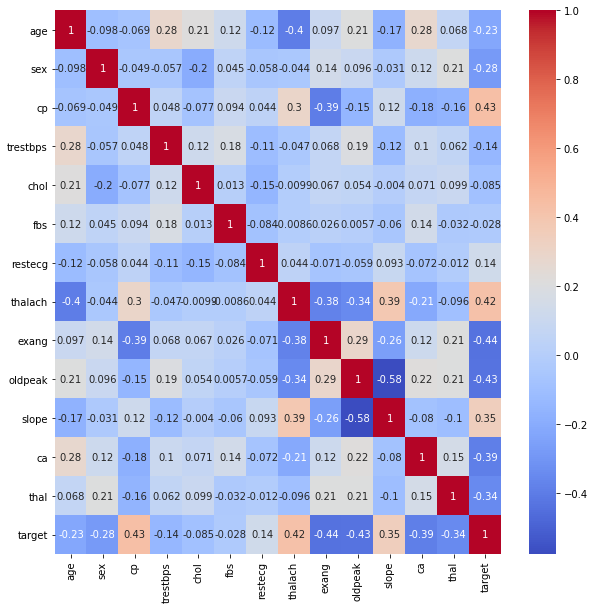

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10,10))
_ = sns.heatmap(df.corr(), cmap='coolwarm', annot=True)

There are no obviously strong correlations.

Let's now see how balanced our data is by sex:

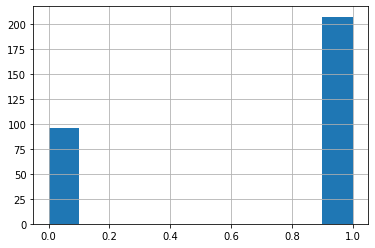

In [7]:
df['sex'].hist()

In this data female maps to 0 and male maps to 1, so there are over twice as many men in the dataset.

Let's also check out the target.

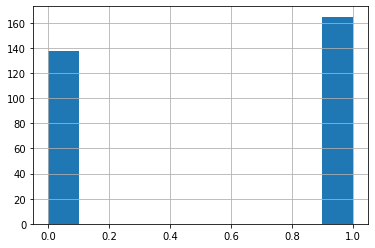

In [8]:
df['target'].hist()

In this case the dataset looks more balanced.

And finally we'll look at age.

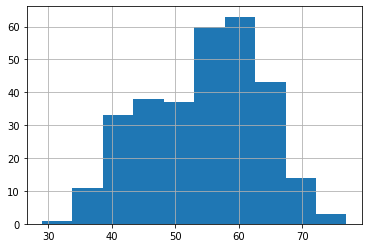

In [9]:
df['age'].hist()

The dataset seems to be pretty heavily skewed toward individuals in their 50s and 60s.

There isn't a lot of actionable information from our analysis. We might want to stratify our data by sex when we train and test our model, but there are no data repairs that seem to need to be done.

If you were building this model for a real world application, you would also want to ensure that the values in the numeric columns are realistic.

## The Model

Let's build and train our model. We'll build a deep neural network that takes our input features and returns a `0` if it predicts that the patient doesn't have heart disease and a `1` if it predicts that the patient does have heart disease.

First let's create a list of features to make coding easier.

In [10]:
FEATURES = df.columns.values[:-1]
TARGET = df.columns.values[-1]

FEATURES, TARGET

(array(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
        'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal'], dtype=object),
 'target')

We'll also want to normalize our feature data before feeding it into the model.

In [11]:
df.loc[:, FEATURES] = ((df[FEATURES] - df[FEATURES].min()) / (df[FEATURES].max() - df[FEATURES].min()))

df.describe()

,age,sex,cp,trestbps,chol,fbs,restecg,thalach,exang,oldpeak,slope,ca,thal,target
count,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000,303.000000
mean,0.528465,0.683168,0.322332,0.354941,0.274575,0.148515,0.264026,0.600358,0.326733,0.167678,0.699670,0.182343,0.771177,0.544554
std,0.189210,0.466011,0.344017,0.165454,0.118335,0.356198,0.262930,0.174849,0.469794,0.187270,0.308113,0.255652,0.204092,0.498835
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.385417,0.000000,0.000000,0.245283,0.194064,0.000000,0.000000,0.477099,0.000000,0.000000,0.500000,0.000000,0.666667,0.000000
50%,0.541667,1.000000,0.333333,0.339623,0.260274,0.000000,0.500000,0.625954,0.000000,0.129032,0.500000,0.000000,0.666667,1.000000
75%,0.666667,1.000000,0.666667,0.433962,0.339041,0.000000,0.500000,0.725191,1.000000,0.258065,1.000000,0.250000,1.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


We can also now split off a validation set from our data. Since we have so many more men than women in this dataset, we will stratify on sex.

In [12]:
from sklearn.model_selection import train_test_split

X_train, X_validate, y_train, y_validate = train_test_split(
    df[FEATURES], df[TARGET], test_size=0.2, stratify=df['sex'])

X_train.shape, X_validate.shape

((242, 13), (61, 13))

We'll use the TensorFlow Keras [`Sequential`](https://www.tensorflow.org/api_docs/python/tf/keras/Sequential) model. The input size needs to be equal to the number of input features that we have. The output size needs to be 1 since we are predicting a yes/no value. The number and width of layers in between are an area for experimentation, as are the activation functions.

We start with an initial hidden layer 64 nodes wide and funnel down to 32, 16, and finally, to the output layer of 1 node.

In [13]:
import tensorflow as tf

model = tf.keras.Sequential([
    tf.keras.layers.Dense(64, activation=tf.nn.relu, 
                          input_shape=(FEATURES.size,)),
    tf.keras.layers.Dense(32, activation=tf.nn.relu),
    tf.keras.layers.Dense(16, activation=tf.nn.relu),
    tf.keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                896       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_2 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 17        
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
_________________________________________________________________


We can now compile the model. We use 'binary_crossentropy' loss since this is a binary classification model.

In [14]:
model.compile(
    loss='binary_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

And finally, we can actually fit the model. We'll start with a run of 500 training epochs. Once we are done, we'll print out the final accuracy the model achieved.

In [15]:
history = model.fit(X_train, y_train, epochs=500, verbose=1)

history.history['accuracy'][-1]

Epoch 1/500
8/8 [==============================] - 1s 2ms/step - loss: 0.6981 - accuracy: 0.4511
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6831 - accuracy: 0.6977
Epoch 3/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6719 - accuracy: 0.6933
Epoch 4/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6611 - accuracy: 0.7304
Epoch 5/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6477 - accuracy: 0.7182
Epoch 6/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6180 - accuracy: 0.7892
Epoch 7/500
8/8 [==============================] - 0s 2ms/step - loss: 0.5956 - accuracy: 0.7931
Epoch 8/500
8/8 [==============================] - 0s 2ms/step - loss: 0.5576 - accuracy: 0.8323
Epoch 9/500
8/8 [==============================] - 0s 2ms/step - loss: 0.5386 - accuracy: 0.8035
Epoch 10/500
8/8 [==============================] - 0s 2ms/step - loss: 0.5058 - accuracy: 0.7902
Epoch 11/500
8/8 [===========

1.0

We got perfect accuracy in our model. Let's see how the accuracy improves and the loss is reduced over epochs.

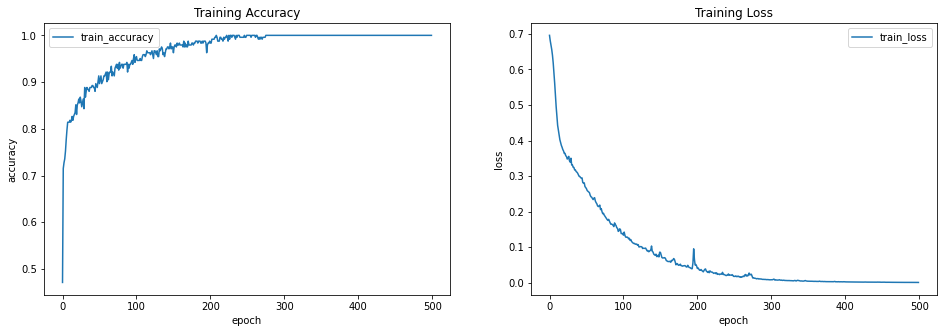

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='best')

We seem to have kept training this model far too long. The accuracy reaches perfection, and the loss moves to 0.0 after a few hundred epochs.

Let's see if we overfit by using our validation holdout data. In order to do that, we need to convert our predictions back into a binary representation.

In [17]:
predictions = model.predict(X_validate)

predictions[:10]

array([[9.4417506e-01],
       [2.5808640e-05],
       [2.5440750e-08],
       [1.8727364e-07],
       [1.3573307e-01],
       [4.5623412e-05],
       [9.9999785e-01],
       [6.3613639e-30],
       [9.9999905e-01],
       [9.9999428e-01]], dtype=float32)

As you can see, our predictions are continuous numbers, not the 1 or 0 values that we expected. These values are confidences that the value is 1. Let's look at them in a histogram.

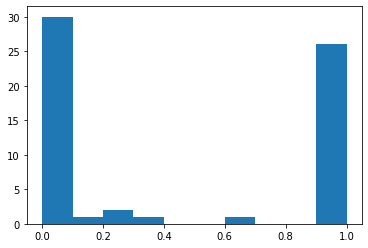

In [18]:
import matplotlib.pyplot as plt

_ = plt.hist(predictions)

Here we can see that the model is highly confident yes or no in many cases, but there are some cases where the model was unsure.

How do we convert these confidences into a yes/no decision?

One way is to simply round:

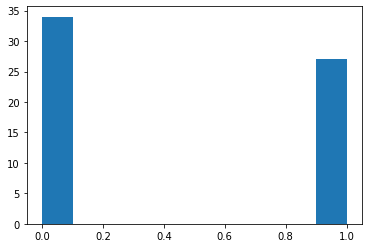

In [19]:
predictions = [round(x[0]) for x in predictions]

_ = plt.hist(predictions)

This puts the cut-off threshold for a yes/no decision at `0.5`. Let's think about the implications of this.

Also note that the choice of a sigmoid activation function was not coincidence. We wanted to use an activation function that would keep the output values between 0.0 and 1.0 for rounding purposes. 

Now let's check our accuracy.

In [20]:
from sklearn.metrics import accuracy_score

accuracy_score(y_validate, predictions)

0.7868852459016393

When we ran this model, our score was in the low 80s, which is not great. Yours is likely similar.

### Exercise 2: Adjusting the Threshold

#### Question 1

We decided to round for our classification, which puts the threshold for the decision at `0.5`. This decision was made somewhat arbitrarily. Let's think about our problem space a bit more. We are making a model that predicts if an individual has heart disease. Would it be better if we set the threshold for predicting heart disease higher or lower than `0.5`? Or is `0.5` okay? Explain your reasoning.


##### **Student Solution**

> In my opinion, if we set threshold too high or too low, we will get higher false positive or false negative. That will become a bad model. But for me, the best threshold is about 0.7-0.8. Try the model between that threshold and test the threshold by getting the (TP, FP, TN, FN)

* TP = True Positive
* FP = False Positive
* TN = True Negative
* FN = False Negative

---

#### Question 2

Write code to make yes/no predictions using a higher or lower threshold based on the argument you made in the first question of this exercise. If you chose to keep the threshold at `0.5`, then just pick higher or lower and write the code for that. Print out the accuracy for the new threshold.

##### **Student Solution**

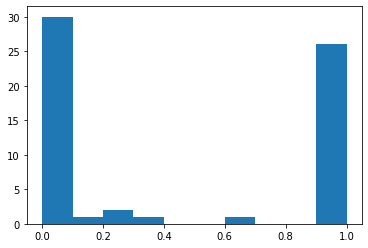

In [21]:
# Your Code Goes Here
import matplotlib.pyplot as plt

predictions = model.predict(X_validate)
_ = plt.hist(predictions)

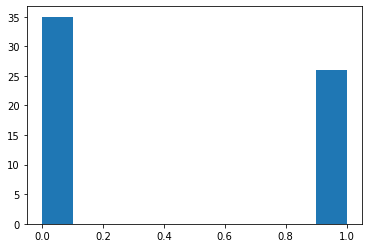

In [22]:
import numpy as np

THRESHOLD = 0.8

higher_threshold = [1 if x >= THRESHOLD else 0 for x in predictions]
higher_threshold = np.array(higher_threshold)

_ = plt.hist(higher_threshold)

In [23]:
from sklearn.metrics import accuracy_score

accuracy_score(y_validate, higher_threshold)

0.7704918032786885

---

### Exercise 2: Early Stopping

Five hundred epochs turned out to be a bit too many. Use the [`EarlyStopping`](https://www.tensorflow.org/api_docs/python/tf/keras/callbacks/EarlyStopping) class to stop when the loss doesn't improve over the course of five epochs. Print your accuracy score so you can see if it stayed reasonably close to your earlier model. Be sure to also make model fitting verbosity 1 or 2 so you can see at which epoch your model stopped.

##### **Student Solution**

In [37]:
# Your code goes here
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split


FEATURES = df.columns.values[:-1]
TARGET = df.columns.values[-1]

df.loc[:, FEATURES] = ((df[FEATURES] - df[FEATURES].min()) / (df[FEATURES].max() - df[FEATURES].min()))

X_train, X_validate, y_train, y_validate = train_test_split(
    df[FEATURES], df[TARGET], test_size=0.2, stratify=df['sex'])

X_train.shape, X_validate.shape

model = keras.Sequential([keras.layers.Dense(64, activation=tf.nn.relu,
                                             input_shape=(FEATURES.size, )),
                          keras.layers.Dense(32, activation=tf.nn.relu),
                          keras.layers.Dense(16, activation=tf.nn.relu),
                          keras.layers.Dense(1, activation=tf.nn.sigmoid)
])

model.summary()

model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

callbacks = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-3, patience=5)

history = model.fit(X_train, y_train, 
                    epochs=500, callbacks=[callbacks], verbose=1)

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_28 (Dense)             (None, 64)                896       
_________________________________________________________________
dense_29 (Dense)             (None, 32)                2080      
_________________________________________________________________
dense_30 (Dense)             (None, 16)                528       
_________________________________________________________________
dense_31 (Dense)             (None, 1)                 17        
Total params: 3,521
Trainable params: 3,521
Non-trainable params: 0
_________________________________________________________________
Epoch 1/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6987 - accuracy: 0.5616
Epoch 2/500
8/8 [==============================] - 0s 2ms/step - loss: 0.6697 - accuracy: 0.5577
Epoch 3/500
8/8 [==============================] - 0s 2m

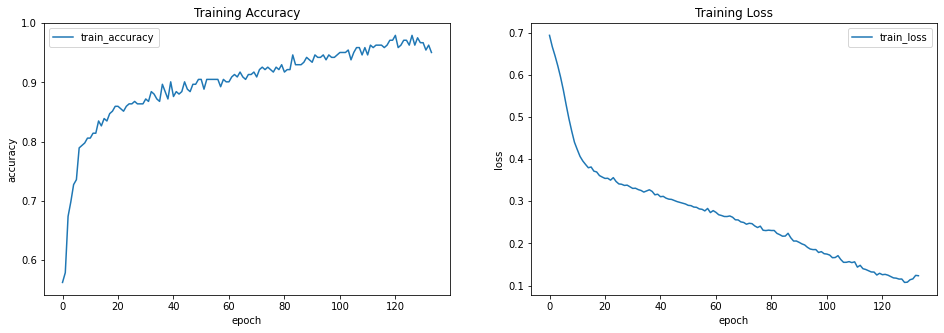

In [38]:
import matplotlib.pyplot as plt

plt.figure(figsize=(16,5))

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'])
plt.title('Training Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy'], loc='best')

plt.subplot(1,2,2)
plt.plot(history.history['loss'])
plt.title('Training Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss'], loc='best')

In [40]:
import numpy as np
from sklearn.metrics import accuracy_score

predictions = model.predict(X_validate)

THRESHOLD = 0.75

new_predict = [1 if x >= THRESHOLD else 0 for x in predictions]
new_predict = np.array(new_predict)

accuracy_score(y_validate, new_predict)

0.8524590163934426

---